# Exploratory data analysis notebook

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 5]

# Data input

For each triple (gene, truth, reference), we know the nb of truth variants in that gene (max_recall), the nb of truth variants snippy was able to call (observed_recall) and thus the recall performance (recall_ratio = observed_recall / max_recall). We also know the edit distance of the gene between the ref and the truth (distance).

In [4]:
df_pandora_precision = pd.read_csv("/home/leandro/git/snippy_calls_gene_distance/tmp/evaluating_calls_output_pandora_no_denovo_100x/get_gene_truth_ref_precision_proportion_distance/all_gene_truth_ref_precision_proportion_distance.csv")
df_pandora_precision["tool"] = "pandora"
df_snippy_precision = pd.read_csv("/home/leandro/git/snippy_calls_gene_distance/tmp/evaluating_calls_output_snippy/get_gene_truth_ref_precision_proportion_distance/all_gene_truth_ref_precision_proportion_distance.csv")
df_snippy_precision["tool"] = "snippy"
df_precision = pd.concat([df_pandora_precision, df_snippy_precision], ignore_index = True)
display(df_precision)

df_pandora_recall = pd.read_csv("/home/leandro/git/snippy_calls_gene_distance/tmp/evaluating_calls_output_pandora_no_denovo_100x/get_gene_truth_ref_recall_proportion_distance/all_gene_truth_ref_recall_proportion_distance.csv")
df_pandora_recall["tool"] = "pandora"
df_snippy_recall = pd.read_csv("/home/leandro/git/snippy_calls_gene_distance/tmp/evaluating_calls_output_snippy/get_gene_truth_ref_recall_proportion_distance/all_gene_truth_ref_recall_proportion_distance.csv")
df_snippy_recall["tool"] = "snippy"
df_recall = pd.concat([df_pandora_recall, df_snippy_recall], ignore_index = True)
display(df_recall)

,gene,truth,ref,distance,max_precision,observed_precision,precision_ratio,tool
0,Cluster_0,CFT073,pandora_vcf_ref_no_denovo,0.000000,8,8.000000,1.000000,pandora
1,Cluster_10,CFT073,pandora_vcf_ref_no_denovo,0.002004,3,3.000000,1.000000,pandora
2,Cluster_1001,CFT073,pandora_vcf_ref_no_denovo,0.065375,10,9.961538,0.996154,pandora
3,Cluster_1007,CFT073,pandora_vcf_ref_no_denovo,0.000000,1,1.000000,1.000000,pandora
4,Cluster_1009,CFT073,pandora_vcf_ref_no_denovo,0.002433,15,15.000000,1.000000,pandora
...,...,...,...,...,...,...,...,...
4244218,GC00010497,063_STEC,CP010140.1,0.026144,8,8.000000,1.000000,snippy
4244219,GC00010606,063_STEC,CP010140.1,0.067633,4,4.000000,1.000000,snippy
4244220,GC00010787,063_STEC,CP010140.1,0.020080,4,4.000000,1.000000,snippy
4244221,GC00010870,063_STEC,CP010140.1,0.015152,2,2.000000,1.000000,snippy


,gene,truth,ref,distance,max_recall,observed_recall,recall_ratio,tool
0,Cluster_10028,H131800734,pandora_vcf_ref_no_denovo,0.043478,5,5.0,1.000000,pandora
1,Cluster_10085,H131800734,pandora_vcf_ref_no_denovo,0.013333,6,0.0,0.000000,pandora
2,Cluster_1009,H131800734,pandora_vcf_ref_no_denovo,0.004866,6,5.0,0.833333,pandora
3,Cluster_10093,H131800734,pandora_vcf_ref_no_denovo,0.010989,2,2.0,1.000000,pandora
4,Cluster_10094,H131800734,pandora_vcf_ref_no_denovo,0.021978,5,5.0,1.000000,pandora
...,...,...,...,...,...,...,...,...
9409352,GC00010496,063_STEC,CP010140.1,0.030864,12,8.0,0.666667,snippy
9409353,GC00010497,063_STEC,CP010140.1,0.026144,9,6.0,0.666667,snippy
9409354,GC00010787,063_STEC,CP010140.1,0.020080,5,5.0,1.000000,snippy
9409355,GC00010870,063_STEC,CP010140.1,0.015152,3,3.0,1.000000,snippy


# Main helper functions

In [5]:
import seaborn as sns
sns.set()
import pandas as pd
import matplotlib.pyplot as plt

def get_bounds(step, max_bin):
    bounds = [0.0]
    current_step = step
    while current_step <= max_bin:
        bounds.append(current_step)
        current_step += step
    assert len(bounds) > 0
    return bounds

def get_edit_distances(row, bounds):
    distance = row["distance"]
    for upper_bound in bounds[1:]:
        if distance < upper_bound:
            return upper_bound
    return bounds[-1]

def get_df_with_edit_distance_labels (df, max_precision_or_recall_column, having_at_least_n_variants, step, max_bin):
    df = df.query(f"{max_precision_or_recall_column} >= @having_at_least_n_variants")
    bounds = get_bounds(step, max_bin)
    edit_distance_labels = df.apply(get_edit_distances, axis=1, bounds=bounds)
    df["edit_distance_labels"] = edit_distance_labels
    return df

def get_df_with_edit_distance_labels_for_precision (df, step, max_bin):
    return get_df_with_edit_distance_labels(df, max_precision_or_recall_column="max_precision",
                                     having_at_least_n_variants=1, step=step, max_bin=max_bin)

def get_df_with_edit_distance_labels_for_recall (df, step, max_bin):
    return get_df_with_edit_distance_labels(df, max_precision_or_recall_column="max_recall",
                                     having_at_least_n_variants=1, step=step, max_bin=max_bin)

def init_plot(figsize=(20, 5)):
    fig, ax = plt.subplots(figsize=figsize)
    return fig, ax

def save_figure(fig, output_filepath):
    fig.savefig(output_filepath, format="png", dpi=600)
    
def plot_lineplot_mean_precision_or_recall_in_genes_in_several_bins(df, recall_or_precision_ratio, step, output_filepath):
    fig, ax = init_plot()
    ax.set_xlabel(f"Edit distance (gene bins at each {step * 100}%)")
    ax.set_xlim([0.0, 0.25])
    ax.set_ylabel(f'Mean {recall_or_precision_ratio} per bin')
    ax.set_ylim([0.0, 1.05])
    sns.lineplot(x="edit_distance_labels", y=recall_or_precision_ratio, data=df, hue="tool")
    
    # TODO: change it back
    # save_figure(fig, output_filepath)
    ax.plot()    


def plot_lineplot_mean_precision_in_genes_in_several_bins(df, step, output_filepath):
    plot_lineplot_mean_precision_or_recall_in_genes_in_several_bins(df, "precision_ratio", step, output_filepath)

def plot_lineplot_mean_recall_in_genes_in_several_bins(df, step, output_filepath):
    plot_lineplot_mean_precision_or_recall_in_genes_in_several_bins(df, "recall_ratio", step, output_filepath)

    
def plot_lineplot_count_in_genes_in_several_bins(df, step, output_filepath):
    fig, ax = init_plot()
    count_df = df.groupby(by=["edit_distance_labels", "tool"], as_index=False).count()
    ax.set_xlabel(f"Edit distance (gene bins at each {step * 100}%)")
    ax.set_xlim([0.0, 0.25])
    ax.set_ylabel("Number of genes per bin")
    sns.lineplot(x="edit_distance_labels", y="gene", data=count_df, hue="tool")
    
    # TODO: change it back
    # save_figure(fig, output_filepath)
    ax.plot()

    
    
    
    
def plot_violinplot_precision_or_recall_in_genes_in_several_bins(df, recall_or_precision_ratio, step, scale, output_filepath):
    fig, ax = init_plot()
    sns.violinplot(x="edit_distance_labels", y=recall_or_precision_ratio, data=df, scale=scale)
    ax.set(xlabel=f"Edit distance (gene bins at each {step*100}%)", ylabel=f'{recall_or_precision_ratio} per bin')
    ax.set_ylim([-0.25, 1.25])
    save_figure(fig, output_filepath)

def plot_violinplot_precision_in_genes_in_several_bins(df, step, scale, output_filepath):
    plot_violinplot_precision_or_recall_in_genes_in_several_bins(df, "precision_ratio", step, scale, output_filepath)

def plot_violinplot_recall_in_genes_in_several_bins(df, step, scale, output_filepath):
    plot_violinplot_precision_or_recall_in_genes_in_several_bins(df, "recall_ratio", step, scale, output_filepath)

# Cached dfs for easier processing

In [6]:
df_precision_with_step_0001 = get_df_with_edit_distance_labels_for_precision(df_precision, step = 0.001, max_bin = 0.2)
df_precision_with_step_001 = get_df_with_edit_distance_labels_for_precision(df_precision, step = 0.01, max_bin = 0.2)
df_recall_with_step_0001 = get_df_with_edit_distance_labels_for_recall(df_recall, step = 0.001, max_bin = 0.2)
df_recall_with_step_001 = get_df_with_edit_distance_labels_for_recall(df_recall, step = 0.01, max_bin = 0.2)


# Results



## Precision 0.001 bins:

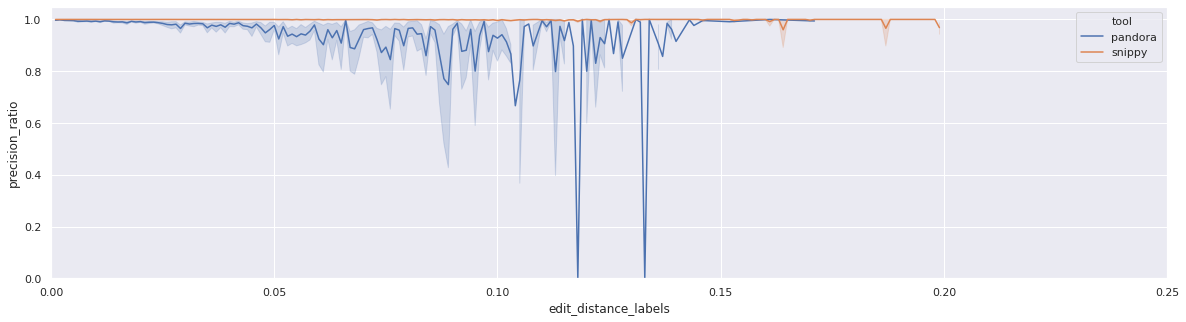

In [7]:
plot_lineplot_mean_precision_in_genes_in_several_bins(df_precision_with_step_0001, step=0.001,
                                                                     output_filepath="whatever")

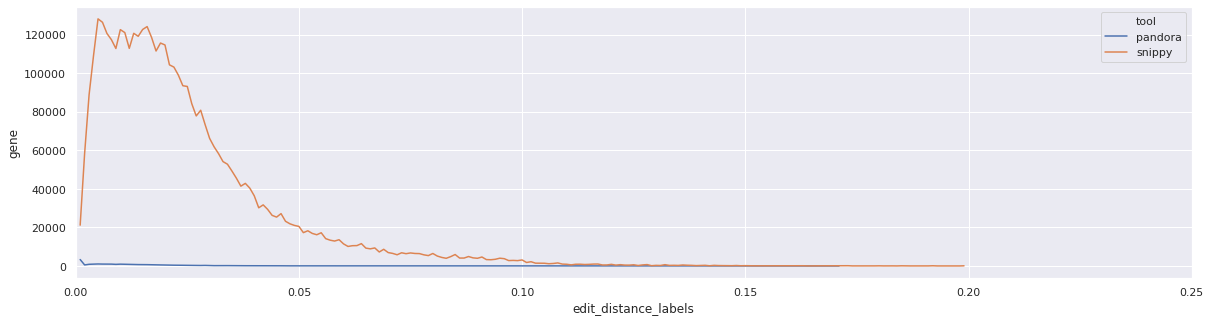

In [8]:
plot_lineplot_count_in_genes_in_several_bins(df_precision_with_step_0001, step=0.001,
                                                                     output_filepath="whatever")

## Precision 0.01 bins:

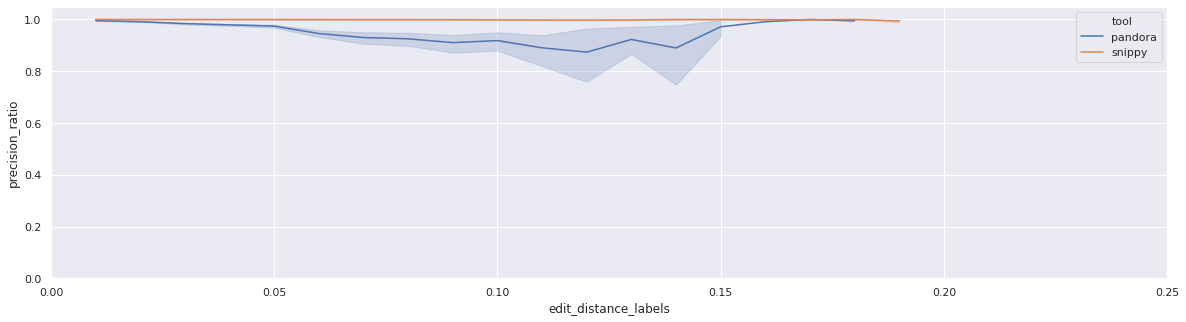

In [9]:
plot_lineplot_mean_precision_in_genes_in_several_bins(df_precision_with_step_001, step=0.01,
                                                                     output_filepath="whatever")

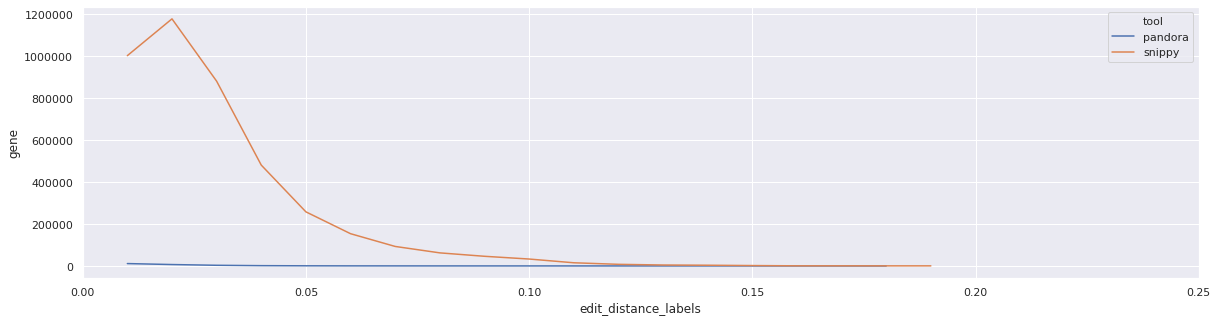

In [11]:
plot_lineplot_count_in_genes_in_several_bins(df_precision_with_step_001, step=0.01,
                                                                     output_filepath="whatever")

## Recall 0.001 bins:

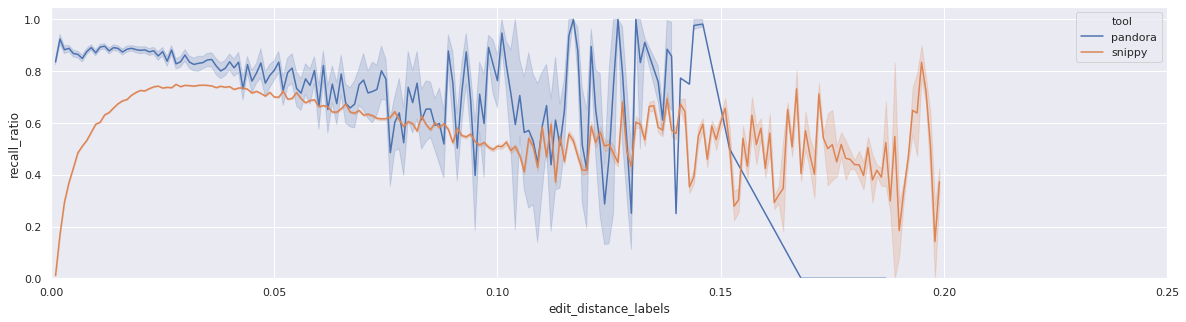

In [12]:
plot_lineplot_mean_recall_in_genes_in_several_bins(df_recall_with_step_0001, step=0.001,
                                                                     output_filepath="whatever")

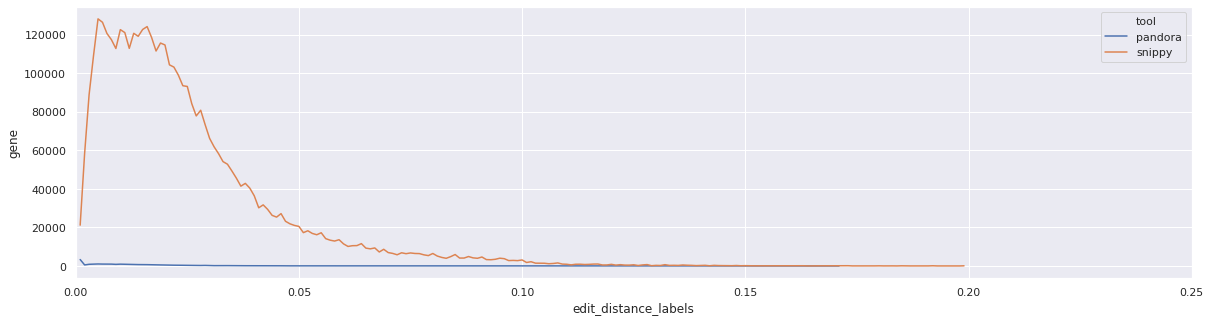

In [15]:
plot_lineplot_count_in_genes_in_several_bins(df_precision_with_step_0001, step=0.001,
                                                                     output_filepath="whatever")

## Recall 0.001 bins:

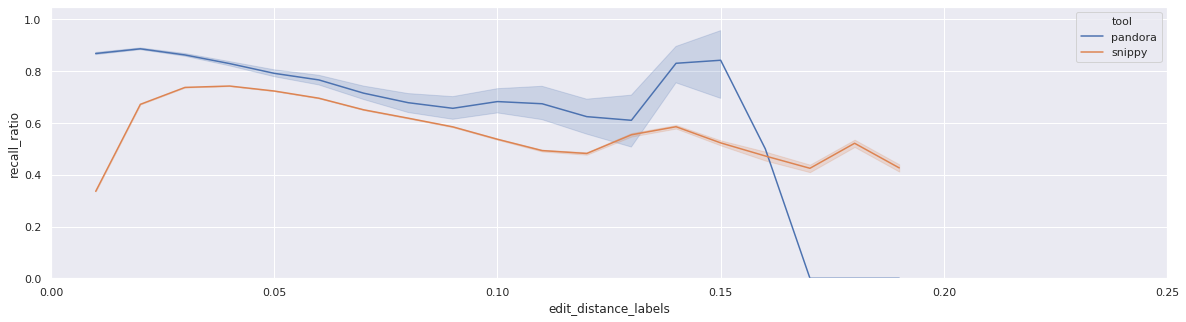

In [16]:
plot_lineplot_mean_recall_in_genes_in_several_bins(df_recall_with_step_001, step=0.01,
                                                                     output_filepath="whatever")

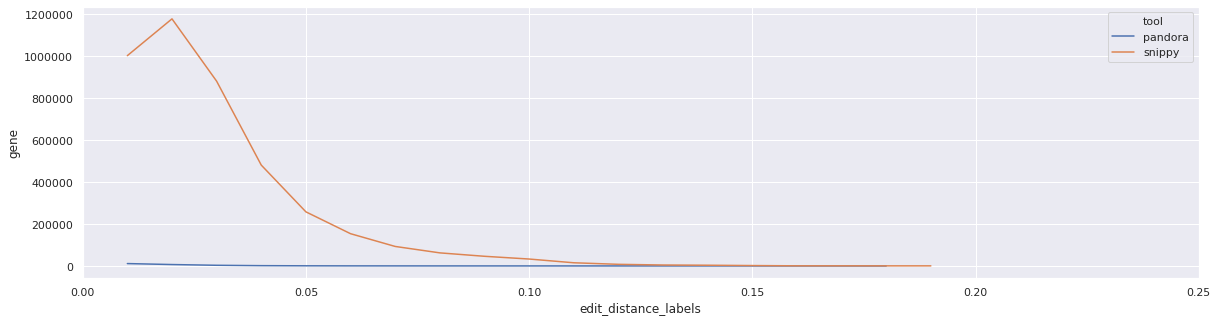

In [17]:
plot_lineplot_count_in_genes_in_several_bins(df_precision_with_step_001, step=0.01,
                                                                     output_filepath="whatever")